In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import xarray_behave as dst
# tighter axis limits
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
# sane imshow size
mpl.rc('image', interpolation='nearest', aspect='auto', origin='lower')

assemble all data, returns an xarray (see [xarray docs](http://xarray.pydata.org/en/stable/index.html))


Assumes the following folder structure:
```
root
 |--datename
     |--dat 
     |    datename_daq.h5
     |    datename_timestamps.h5  
     |    datename.mp4  
     |--res
          datename_tracks_fixes.h5  
          datename_poses.h5  
          datename_song.mat  
          datename_songmanual.mat  
```    
- root: e.g. `/Volumes/ukme04/#Common/chainingmic`
- datename: `computername-YYYYMMDD_HHMMSS`, e.g. `localhost-20190401_130742`

In [2]:
datename = 'localhost-20181120_144618'
root = '/Volumes/ukme04/#Common/chainingmic'
print(datename)
print(f'   assembling data')
dataset = dst.assemble(datename, dat_path='dat', res_path='res')

print(f'   saving to {datename  + ".zarr"}')
dst.save(datename  + '.zarr', dataset)

print(f'   loading from {datename  + ".zarr"}')
dataset = dst.load(datename + '.zarr')

print(dataset)

localhost-20181120_144618
   assembling data
   saving to localhost-20181120_144618.zarr
   loading from localhost-20181120_144618.zarr
<xarray.Dataset>
Dimensions:              (bodyparts: 3, coords: 2, event_types: 5, flies: 2, poseparts: 12, sampletime: 6035114, time: 603512)
Coordinates:
  * bodyparts            (bodyparts) object 'head' 'center' 'tail'
  * coords               (coords) object 'x' 'y'
  * event_types          (event_types) object 'pulse_manual' ... 'sine'
    nearest_frame        (time) uint64 622 623 623 623 ... 60931 60931 60931
  * poseparts            (poseparts) object 'head' 'neck' ... 'tail'
  * sampletime           (sampletime) float64 0.0 0.0001 0.0002 ... 603.5 603.5
  * time                 (time) float64 0.0 0.001 0.002 ... 603.5 603.5 603.5
Dimensions without coordinates: flies
Data variables:
    body_positions       (time, flies, bodyparts, coords) float64 840.5 ... 307.2
    pose_positions       (time, flies, poseparts, coords) float64 -25.55 ... na

In [3]:
dataset.song.attrs

OrderedDict([('amplitude_units', 'volts'),
             ('description',
              'Song signal merged across all recording channels.'),
             ('sampling_rate_Hz', 10000),
             ('time_units', 'seconds')])

While one big advantage of xarrays is fancy/semantic indexing (for instance by time), access to the underlying raw data is also simple:

In [4]:
# use attribute-like (dot-notation) or dict-like notation to access individual variables in the data set - this will return DataArrays
print('song_labels as xarray (attribute-like access):\n', dataset.song_labels)
print('song_labels as xarray (dict-like access):\n', dataset['song_labels'])

# if you want the underlying raw numpy array, simply append the above by `.data`
print('ACCESS RAW DATA:')
print('song_labels as numpy array (attribute-like access):', dataset.song_labels.values)
print('song_labels as numpy array (dict-like access):', dataset['song_labels'].values)

# the same goes for coordinates
print('COORDINATE ACCESS:')
print('nearest_frame:', dataset.nearest_frame.data)
print('time:', dataset['time'].data)

song_labels as xarray (attribute-like access):
 <xarray.DataArray 'song_labels' (time: 603512)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Coordinates:
    nearest_frame  (time) uint64 622 623 623 623 623 ... 60931 60931 60931 60931
  * time           (time) float64 0.0 0.001 0.002 0.003 ... 603.5 603.5 603.5
Attributes:
    description:       Song label for each sample - 0: silence, 1: pulse, 2: ...
    sampling_rate_Hz:  1000.0
    time_units:        seconds
song_labels as xarray (dict-like access):
 <xarray.DataArray 'song_labels' (time: 603512)>
array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)
Coordinates:
    nearest_frame  (time) uint64 622 623 623 623 623 ... 60931 60931 60931 60931
  * time           (time) float64 0.0 0.001 0.002 0.003 ... 603.5 603.5 603.5
Attributes:
    description:       Song label for each sample - 0: silence, 1: pulse, 2: ...
    sampling_rate_Hz:  1000.0
    time_units:        seconds
ACCESS RAW DATA:
song_labels as numpy array (attribute-like access): [0 0

We can address all the different data types - the raw song recording, the song annotations, and the tracked data using time units without having to worry about the different sampling rates.

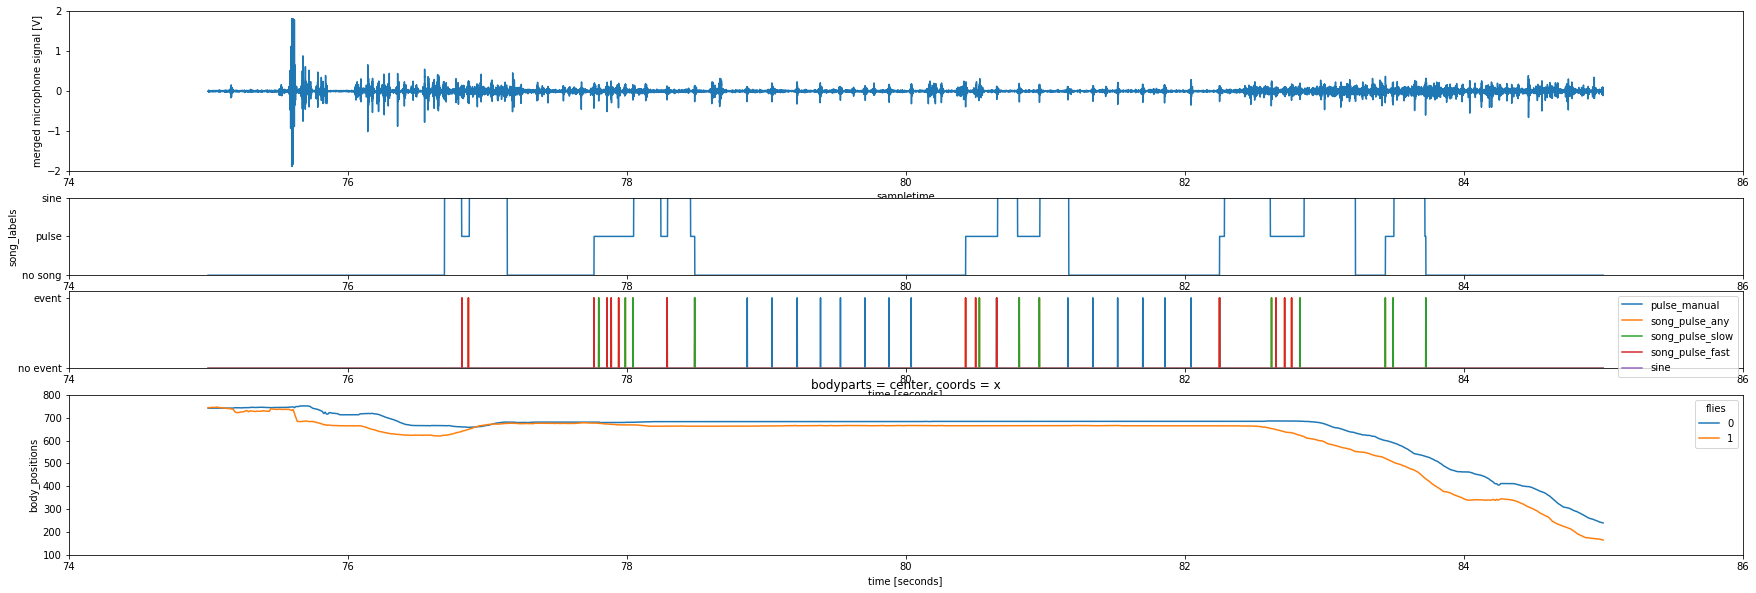

In [5]:
t0 = 75  # seconds
t1 = t0+10  # seconds

plt.gcf().set_size_inches(30, 10)
plt.subplot(311)
dataset.song.sel(sampletime=slice(t0, t1)).plot()  # using the .sel syntax with `slice`
plt.ylabel('merged microphone signal [V]')

plt.subplot(613)
dataset.song_labels.loc[t0:t1].plot()  # or directly using .loc[...]
plt.yticks([0, 1, 2], labels=['no song','pulse','sine'])

plt.subplot(614)
ds = dataset.song_events.sel(time=slice(t0, t1))
plt.plot(ds.time, ds.values)
plt.legend(ds.event_types.values)
plt.ylim(0, 1.1)
plt.yticks([0, 1], labels=['no event','event'])
plt.xlabel('time [seconds]');

plt.subplot(313)
dataset.body_positions.sel(time=slice(t0, t1), bodyparts='center', coords='x').T.plot(x='time', hue='flies')
# equivalent to: `dataset.body_positions.loc[t0:t1, :, 'center', 'x'].T.plot(x='time', hue='flies')`
# but the first variant is preferable because it's more explicit
plt.xlabel('time [seconds]');

<xarray.DataArray 'song_events' (time: 603512, event_types: 5)>
array([[False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])
Coordinates:
  * event_types    (event_types) object 'pulse_manual' ... 'sine'
    nearest_frame  (time) uint64 622 623 623 623 623 ... 60931 60931 60931 60931
  * time           (time) float64 0.0 0.001 0.002 0.003 ... 603.5 603.5 603.5
Attributes:
    description:       Event times as boolean arrays.
    sampling_rate_Hz:  1000.0
    time_units:        seconds


(array([ 289,  488,  865, 1042, 1223, 1390, 1533, 1709, 1881, 2040, 2652,
        2812, 2958, 3163, 3342, 3520, 3700, 3859, 4046, 4252]),)

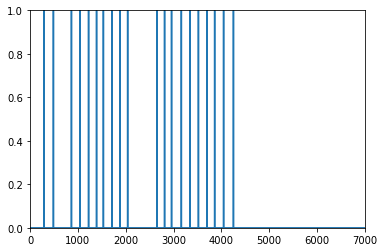

In [6]:
print(dataset.song_events)
plt.plot(dataset.song_events.loc[78:85, 'pulse_manual'])
np.where(dataset.song_events.loc[78:85, 'pulse_manual'])

<xarray.DataArray 'song' (sampletime: 100001)>
array([-0.007, -0.007, -0.005, ...,  0.015,  0.017,  0.008], dtype=float32)
Coordinates:
  * sampletime  (sampletime) float64 75.0 75.0 75.0 75.0 ... 85.0 85.0 85.0 85.0
Attributes:
    amplitude_units:   volts
    description:       Song signal merged across all recording channels.
    sampling_rate_Hz:  10000
    time_units:        seconds
<xarray.DataArray 'song_events' (time: 10001, event_types: 5)>
array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])
Coordinates:
  * event_types    (event_types) object 'pulse_manual' ... 'sine'
    nearest_frame  (time) uint64 8117 8117 8117 8117 ... 9116 9116 9116 9116
  * time           (time) float64 75.0 75.0 75.0 75.0 ... 85.0 85.0 85.0 85.0
Attributes:
    description:       

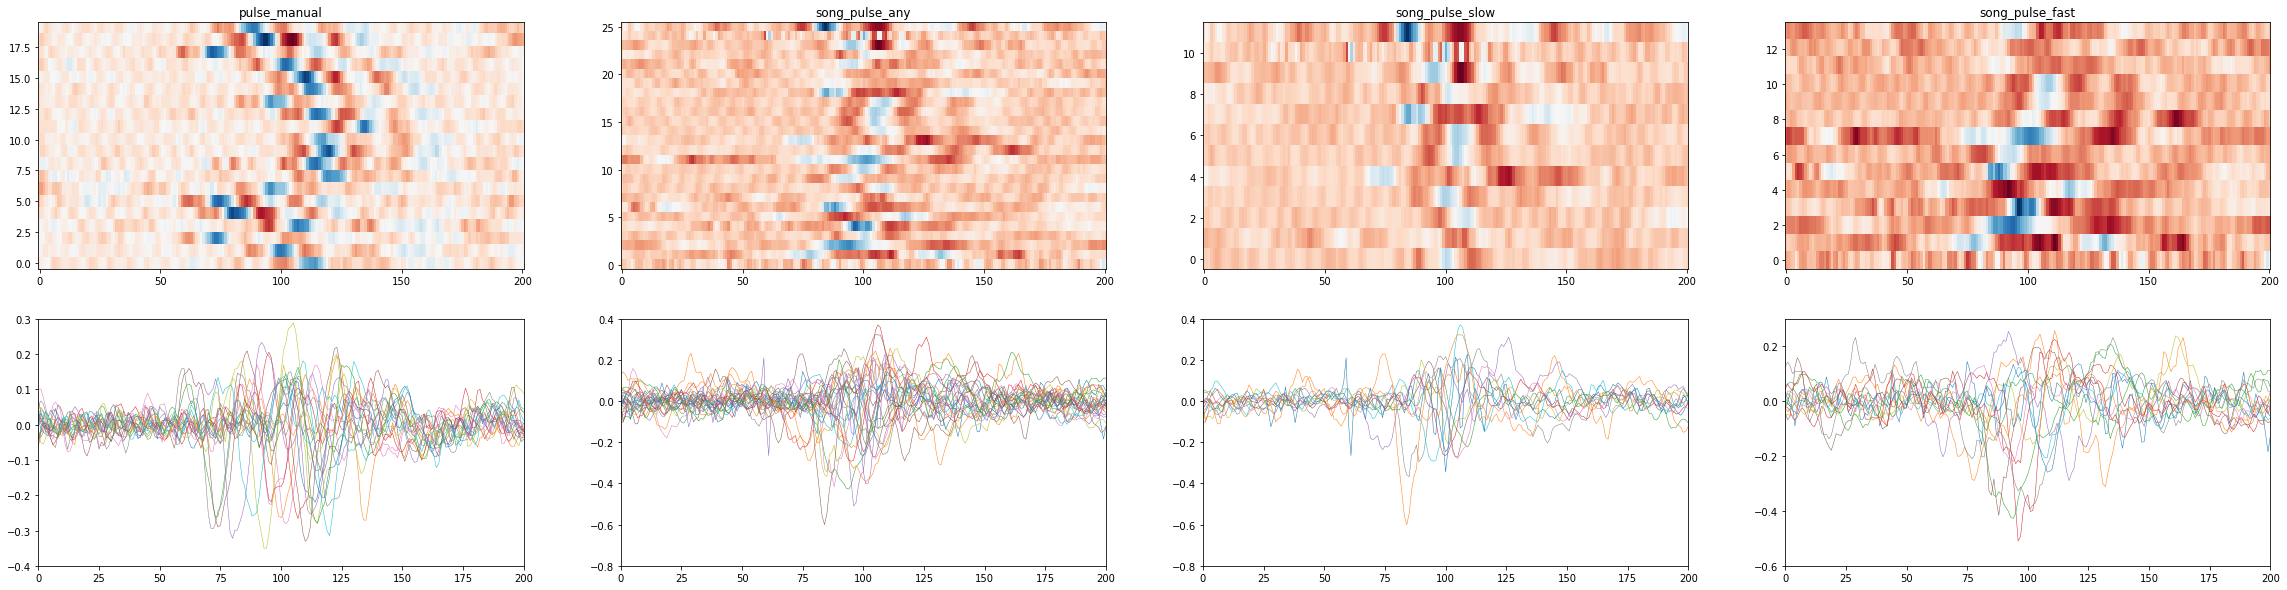

In [7]:
song = dataset.song.sel(sampletime=slice(t0, t1))
print(song)
ds = dataset.song_events.sel(time=slice(t0, t1))
print(ds)
indices, types = np.where(ds.values)
times = ds.time[indices]

waveforms = np.zeros((len(indices), 201))
for cnt, tim in enumerate(times):
    tmp = song.sel(sampletime=slice(tim-0.01, tim+0.01)).values
    waveforms[cnt,: ] = tmp[:1000]

plt.gcf().set_size_inches(40, 10)
for cnt, typ in enumerate(np.unique(types)):
    plt.subplot(2,4, 1+cnt)
    plt.imshow(waveforms[types==typ,:], cmap='RdBu_r');
    plt.title(ds.event_types[typ].values)
    plt.subplot(2,4, 4+1+cnt)
    plt.plot(waveforms[types==typ,:].T, linewidth=0.5);
    

<xarray.DataArray 'pose_positions_allo' (coords: 2)>
array([756, 266], dtype=uint64)
Coordinates:
  * coords         (coords) object 'x' 'y'
    nearest_frame  uint64 3620
    poseparts      <U6 'thorax'
    time           float64 30.0


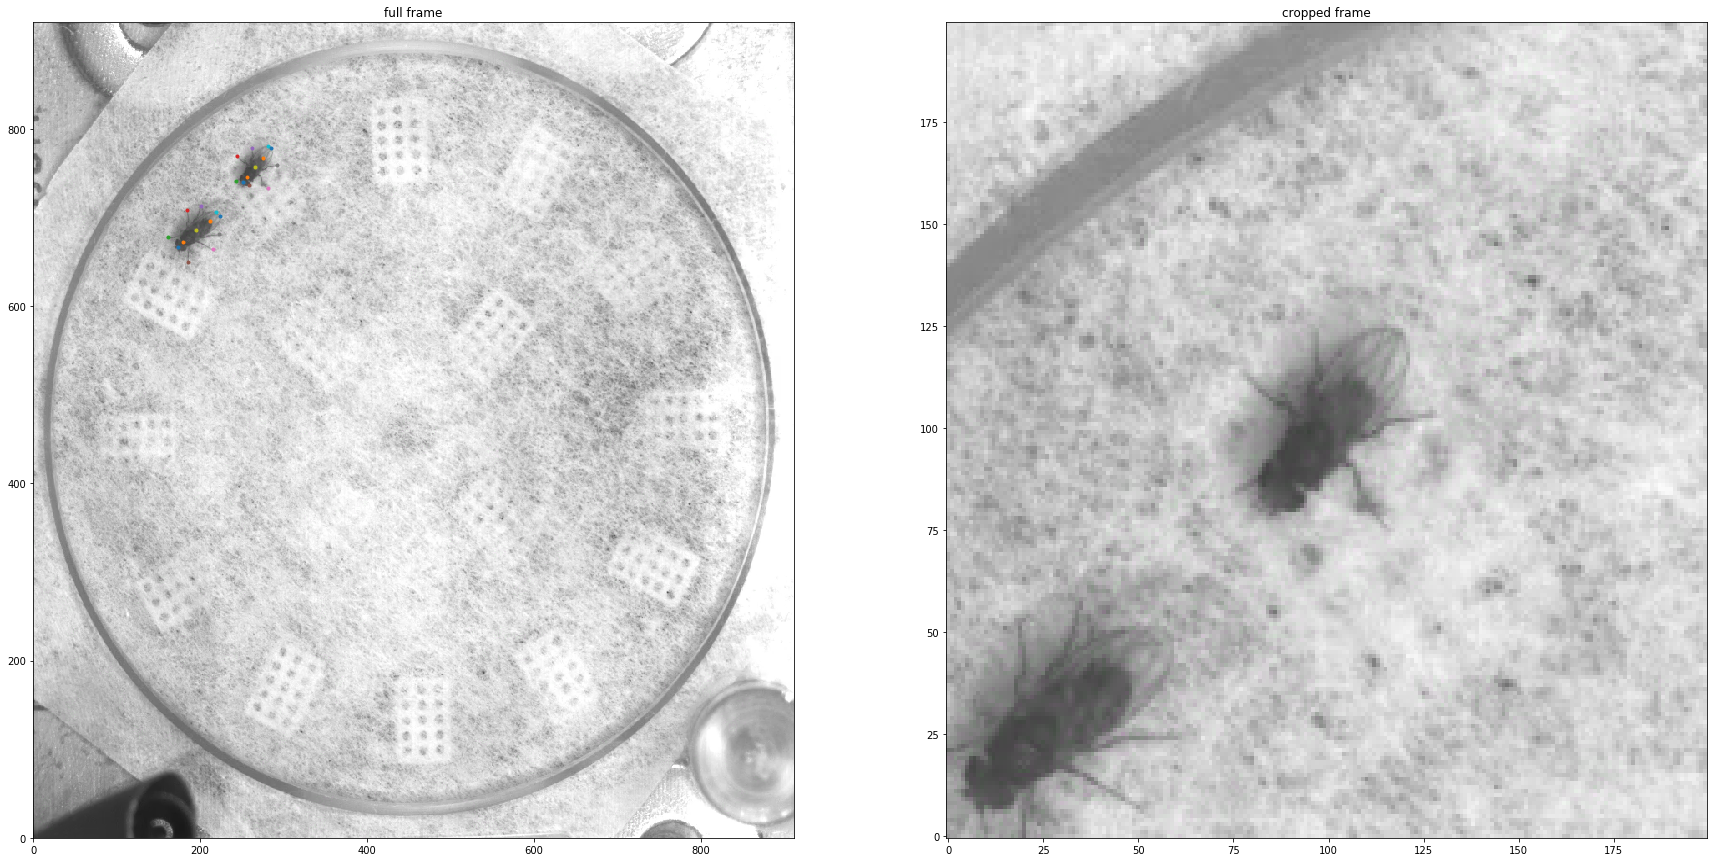

In [12]:
from videoreader import VideoReader
filepath = f'dat/{datename}/{datename}.mp4'
vr = VideoReader(filepath)

time = 30 #seconds
frame_number = dataset.nearest_frame.loc[time]  # get frame number for that idx
frame = vr[frame_number]

plt.gcf().set_size_inches(30,15)
plt.subplot(121)
# print(dataset.pose_positions_allo.loc[time, :,:,:])
plt.imshow(frame, cmap='Greys')
plt.plot(dataset.pose_positions_allo.loc[time, :,:,'y'], dataset.pose_positions_allo.loc[time, :,:,'x'], '.')
plt.xlim(0, frame.shape[1])
plt.ylim(0, frame.shape[0])
plt.title('full frame')

plt.subplot(122)
fly = 0
fly_pos = dataset.pose_positions_allo.loc[time, fly, 'thorax',:].astype(np.uintp)
print(fly_pos)
box_size = np.uintp(100)
x_range = np.clip((fly_pos.loc['x']-box_size, fly_pos.loc['x']+box_size), 0, vr.frame_width-1)
y_range = np.clip((fly_pos.loc['y']-box_size, fly_pos.loc['y']+box_size), 0, vr.frame_height-1)
plt.imshow(frame[slice(*x_range), slice(*y_range), :], cmap='Greys')
plt.title('cropped frame');


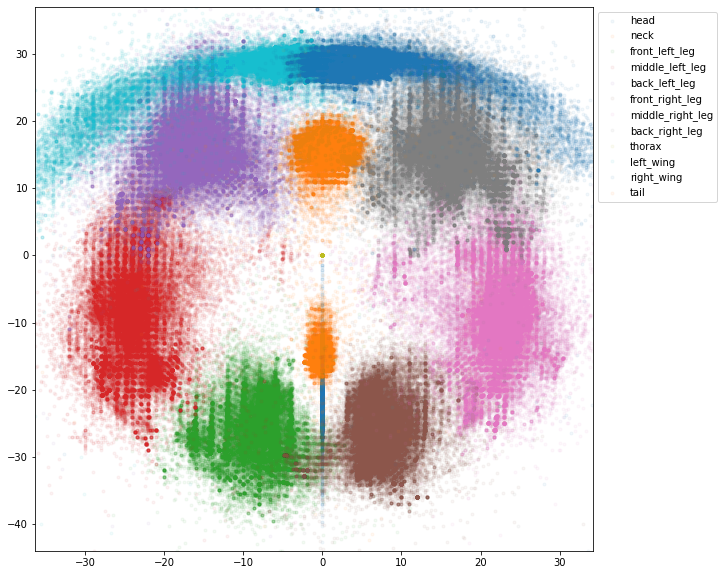

In [9]:
plt.gcf().set_size_inches(10, 10)
plt.plot(dataset.pose_positions[::10,0, :,1], dataset.pose_positions[::10,0, :,0], '.', alpha=0.05)

plt.xlim(*np.nanpercentile(dataset.pose_positions[...,1], (0.1, 99.9)))
plt.ylim(*np.nanpercentile(dataset.pose_positions[...,0], (0.1, 99.9)))

leg = plt.legend(dataset.poseparts.values, loc="upper left", bbox_to_anchor=(1,1))


In [10]:
times = [100.1, 200.1]
frames = dataset.nearest_frame.loc[times]
print(f'frames for times {times}:\n {frames}') # get frame for time
idx = [np.where(dataset.nearest_frame==frame)[0][0] for frame in frames]
print(f'indices for times {times}:\n {idx}') # get frame for time

frames = [9000, 10000]
times = [dataset.time[dataset.nearest_frame==frame][0].values for frame in frames]
print(f'times for frames {frames}:\n {times}') # get frame for time
idx = [np.where(dataset.nearest_frame==frame)[0][0] for frame in frames]
print(f'times for frames {frames}:\n {idx}') # get frame for time


frames for times [100.1, 200.1]:
 <xarray.DataArray 'nearest_frame' (time: 2)>
array([10625, 20618], dtype=uint64)
Coordinates:
    nearest_frame  (time) uint64 10625 20618
  * time           (time) float64 100.1 200.1
indices for times [100.1, 200.1]:
 [100092, 200093]
times for frames [9000, 10000]:
 [array(83.831), array(93.837)]
times for frames [9000, 10000]:
 [83831, 93837]
